In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from tensorflow.keras import layers, Model, optimizers, losses, metrics
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Concatenate, Input, Conv3D, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
import os
from keras.regularizers import l2
from keras.constraints import MinMaxNorm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras import backend as K
tf.keras.backend.set_floatx('float64')

In [2]:
data = pd.read_csv('data/il8andil1.csv')

# define cytokines
cytokines = ['il8', 'il1']

# get unique time values
unique_time = data['time'].unique()

arrays = {}

# iterate over unique time values
for time in unique_time:
    # filter data for current value of time
    data_time = data[data['time'] == time]
    
    # initialize 50x50x6 array for current value of time
    array = np.zeros((50, 50, len(cytokines)))
    
    # get X and Y coordinates
    x = data_time['xCOM'].astype(int)
    y = data_time['yCOM'].astype(int)
    
    # get cytokine concentrations
    concentrations = data_time[['il8', 'il1']].values
    
    # assign cytokine concentrations to corresponding position in array
    array[x, y, :] = concentrations
    
    # store array for current value of time
    arrays[time] = array

In [3]:
sequence_length = 10
input_sequences = []
output_values = []

# convert dictionary values to a list of arrays
arrays_list = [arrays[key] for key in sorted(arrays.keys())]

# convert 'arrays' list to numpy array
arrays_np = np.array(arrays_list)

for i in range(len(arrays_np) - sequence_length):
    input_seq = arrays_np[i:i+sequence_length]  # input sequence of arrays
    output_val = arrays_np[i+sequence_length]   # array at next time step
    
    input_sequences.append(input_seq)
    output_values.append(output_val)

# convert lists to numpy arrays
input_sequences = np.array(input_sequences)
output_values = np.array(output_values)

In [4]:
print(input_sequences.shape)
print(output_values.shape)

(91, 10, 50, 50, 2)
(91, 50, 50, 2)


In [25]:
input_shape = (10, 50, 50, 2)
# model architecture
def model(input_shape):
    input_layer = layers.Input(shape=input_shape)
    
    x = layers.TimeDistributed(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))(input_layer)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    x = layers.TimeDistributed(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    
    x = layers.Reshape((input_shape[0], -1))(x)
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.LSTM(64)(x)
    
    x = layers.Dense(50 * 50 * 2)(x) 
    output_layer = layers.Reshape((50, 50, 2))(x)
    
    return Model(inputs=input_layer, outputs=output_layer)

model = model(input_shape)

In [5]:
input_shape = (10, 50, 50, 2)
def model(input_shape):
    input_layer = layers.Input(shape=input_shape)
   
    x= layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
    x= Reshape((sequence_length, -1))(x)
    x= layers.LSTM(units=64, return_sequences=True, kernel_regularizer=l2(0.01))(x)
    x= layers.LSTM(units=64)(x)
    x= layers.Dense(units=50*50*2, activation='linear')(x)
    output_layer = layers.Reshape((50, 50, 2))(x)

    return Model(inputs=input_layer, outputs=output_layer)

model = model(input_shape)

In [9]:
# Define the parameters for the PDE solver
Dil8 = 2.09e-6  # Diffusion coefficient for IL-8
Dil1 = 3e-7     # Diffusion coefficient for IL-1

muil8 = 0.2     # Degradation rate for IL-8
muil1 = 0.6     # Degradation rate for IL-1

keil8 = 234e-5  # Production rate for IL-8
kndnil8 = 1.46e-5  # Additional source term for IL-8
thetanail8 = 3.024e-5  # Negative feedback/inhibition term for IL-8
knail1 = 225e-5  # Production rate for IL-1



# Define the custom loss layer
class CustomLossLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        y_pred, y_true = inputs
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
        #mape_loss = tf.reduce_mean(tf.abs((y_true - y_pred) / y_true)) * 100
        
        # Compute the physical constraints
        with tf.GradientTape() as tape:
            tape.watch(y_pred)
            il8, il1 = tf.split(y_pred, num_or_size_splits=2, axis=-1)
             # Compute time derivatives
            d_il8_dt = Dil8 * tf.gradients(il8, y_pred)[0] - muil8 * il8 + keil8 * il8 + kndnil8 * il8 - thetanail8 * il8
            d_il1_dt = Dil1 * tf.gradients(il1, y_pred)[0] - muil1 * il1 + knail1 * il1

        physics_loss = tf.reduce_mean(tf.square(d_il8_dt - il8) + tf.square(d_il1_dt - il1))
        
        total_loss = mse_loss + physics_loss
        self.add_loss(total_loss)
        return y_pred

In [6]:
# Metrics and lr schedule callback
def lr_schedule(epoch, lr):
    if epoch < 100:
        return 1e-4
    if epoch < 400:
        return 1e-5
    else:
        return 1e-6

def r_squared(y_true, y_pred):
    SS_res = tf.keras.backend.sum(tf.keras.backend.square(y_true - y_pred))
    SS_tot = tf.keras.backend.sum(tf.keras.backend.square(y_true - tf.keras.backend.mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

def average_relative_rmse(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square((y_pred - y_true) / tf.keras.backend.clip(tf.keras.backend.abs(y_true), tf.keras.backend.epsilon(), None))))

def accuracy(y_true, y_pred):
    abs_diff = K.abs(y_true - y_pred)
    threshold = 0.2 * y_true
    accurate_predictions = K.less_equal(abs_diff, threshold)
    accuracy = K.mean(accurate_predictions)
    return accuracy

In [10]:
# Apply the custom loss layer
y_true = layers.Input(shape=(50, 50, 2))
custom_loss_layer = CustomLossLayer()([model.output, y_true])
final_model = Model(inputs=[model.input, y_true], outputs=custom_loss_layer)

# data split
train_size = int(0.7 * len(input_sequences))
val_size = int(0.1 * len(input_sequences))

X_train, y_train = input_sequences[:train_size], output_values[:train_size]
X_val, y_val = input_sequences[train_size:train_size+val_size], output_values[train_size:train_size+val_size]
X_test, y_test = input_sequences[train_size+val_size:], output_values[train_size+val_size:]

lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=150, verbose=1, restore_best_weights=True)
initial_lr = 1e-4

# compile, fit
final_model.compile(optimizer=Adam(learning_rate=initial_lr),  metrics=[r_squared, 'mape', accuracy, average_relative_rmse, 'msle', 'mae'])

history = final_model.fit([X_train, y_train], y_train, validation_data=([X_val, y_val], y_val), epochs=300, batch_size=40, callbacks=[lr_scheduler, early_stopping])

Epoch 1/300
2/2 [==============================] - 3s 872ms/step - loss: nan - r_squared: nan - mape: nan - accuracy: 0.0076 - average_relative_rmse: nan - msle: nan - mae: nan - val_loss: nan - val_r_squared: nan - val_mape: nan - val_accuracy: 0.0000e+00 - val_average_relative_rmse: nan - val_msle: nan - val_mae: nan - lr: 1.0000e-04
Epoch 2/300
2/2 [==============================] - 1s 312ms/step - loss: nan - r_squared: nan - mape: nan - accuracy: 0.0000e+00 - average_relative_rmse: nan - msle: nan - mae: nan - val_loss: nan - val_r_squared: nan - val_mape: nan - val_accuracy: 0.0000e+00 - val_average_relative_rmse: nan - val_msle: nan - val_mae: nan - lr: 1.0000e-04
Epoch 3/300
2/2 [==============================] - 1s 308ms/step - loss: nan - r_squared: nan - mape: nan - accuracy: 0.0000e+00 - average_relative_rmse: nan - msle: nan - mae: nan - val_loss: nan - val_r_squared: nan - val_mape: nan - val_accuracy: 0.0000e+00 - val_average_relative_rmse: nan - val_msle: nan - val_mae:

KeyboardInterrupt: 

In [15]:
y_pred = model.predict(X_test)

loss = final_model.evaluate([X_test, y_test], y_test)
print(f'Test Loss: {loss}')

1/1 [==============================] - 0s 94ms/step - loss: 4.8444e-55 - custom_loss_layer_1_r_squared: 0.2517 - custom_loss_layer_1_mape: 308.0717 - custom_loss_layer_1_accuracy: 0.0109 - custom_loss_layer_1_average_relative_rmse: 4.8187 - custom_loss_layer_1_msle: 2.3089e-11 - custom_loss_layer_1_mae: 1.9594e-06 - custom_loss_layer_1_1_r_squared: 1.0000 - custom_loss_layer_1_1_mape: 0.0000e+00 - custom_loss_layer_1_1_accuracy: 1.0000 - custom_loss_layer_1_1_average_relative_rmse: 0.0000e+00 - custom_loss_layer_1_1_msle: 0.0000e+00 - custom_loss_layer_1_1_mae: 0.0000e+00
Test Loss: [4.8444463598863296e-55, 0.25168889417365037, 308.07170035602604, 0.010894736842105263, 4.818745410084674, 2.308850786541349e-11, 1.9593616323603693e-06, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]


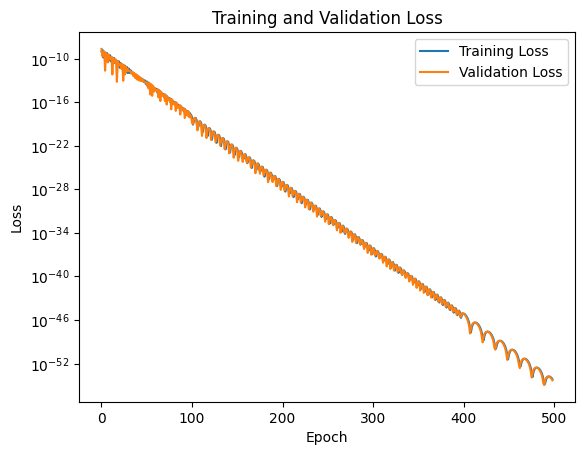

In [16]:
train_loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]

output_dir = 'plots-PINN'
os.makedirs(output_dir, exist_ok=True)

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# save the plot to the specified folder
plot_filename = f'loss.png'
plot_path = os.path.join(output_dir, plot_filename)
plt.savefig(plot_path)
plt.show()

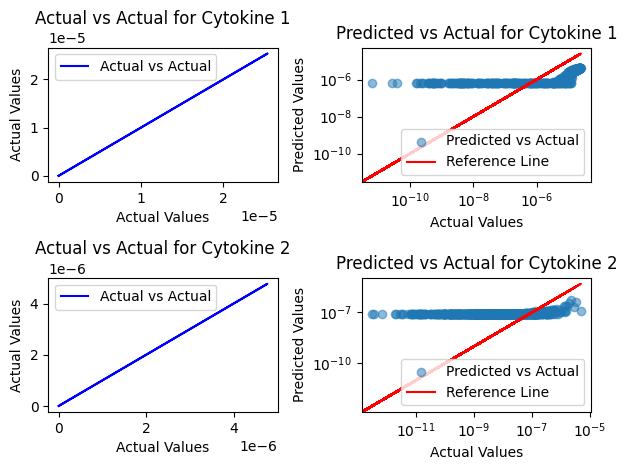

In [17]:
import matplotlib.pyplot as plt

index = 0

# Flattened plots for actual and predicted values for il8 and il1
for i in range(2):
    actual = y_test[index, :, :, i].flatten()
    predicted = y_pred[index, :, :, i].flatten()
    
    # Plot the reference line for actual vs actual
    plt.subplot(2, 2, i*2 + 1)
    plt.plot(actual, actual, 'b-', label='Actual vs Actual')
    plt.title(f'Actual vs Actual for Cytokine {i+1}')
    plt.xlabel('Actual Values')
    plt.ylabel('Actual Values')
    plt.legend()
    
    # Plot predicted vs actual
    plt.subplot(2, 2, i*2 + 2)
    plt.scatter(actual, predicted, label='Predicted vs Actual', alpha=0.5)
    plt.plot(actual, actual, 'r-', label='Reference Line')
    plt.title(f'Predicted vs Actual for Cytokine {i+1}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()

plt.tight_layout()
plt.show()